# 케라스 보스턴 주택 가격 모델

<br>

### modules import

In [39]:
import tensorflow as tf
from tensorflow.keras.datasets.boston_housing import load_data
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split, KFold

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<br>

### 데이터 로드
- **데이터의 수가 상당히 적기 때문에 테스트 데이터의 비율을 20%로 지정**

- 13개의 특성을 가짐

- **각각의 특성이 모두 다른 스케일, 즉 단위가 모두 다름**
  - 범죄율: 0~1 사이의 값 
  - 방의 개수 3~9 사이의 값

- 정답 레이블은 주택 가격의 중간가격($1000 단위)

In [4]:
tf.random.set_seed(123)

(x_train_full, y_train_full), (x_test, y_test) = load_data(path='boston_housing.npz', test_split=0.2, seed=111)

57026/57026 [==============================] - 0s 0us/step


<br>

### 데이터 확인

In [5]:
print("학습 데이터: {}\t레이블: {}".format(x_train_full.shape, y_train_full.shape))
print("테스트 데이터: {}\t레이블 {}".format(x_test.shape, y_test.shape))

학습 데이터: (404, 13)	레이블: (404,)
테스트 데이터: (102, 13)	레이블 (102,)


In [6]:
print(x_train_full[0])

[2.8750e-02 2.8000e+01 1.5040e+01 0.0000e+00 4.6400e-01 6.2110e+00
 2.8900e+01 3.6659e+00 4.0000e+00 2.7000e+02 1.8200e+01 3.9633e+02
 6.2100e+00]


In [7]:
print(y_train_full[0])

25.0


<br>

### 데이터 전처리
- Standardization

- 특성의 단위가 모두 다르기 때문에 **동일한 범위로 조정**

In [10]:
mean = np.mean(x_train_full, axis=0)
std = np.std(x_train_full, axis=0)

x_train_preprocessed = (x_train_full - mean) / std
x_test_preprocessed = (x_test - mean) / std

x_train, x_val, y_train, y_val = train_test_split(x_train_preprocessed, y_train_full,
                                                  test_size=0.3, random_state=111)

In [12]:
print("전체 학습 데이터:{} \t레이블: {}".format(x_train_full.shape, y_train_full.shape))
print("학습 데이터:{} \t레이블: {}".format(x_train.shape, y_train.shape))
print("검증 데이터:{} \t레이블: {}".format(x_val.shape, y_val.shape))
print("테스트 데이터:{} \t레이블: {}".format(x_test.shape, y_test.shape))

전체 학습 데이터:(404, 13) 	레이블: (404,)
학습 데이터:(282, 13) 	레이블: (282,)
검증 데이터:(122, 13) 	레이블: (122,)
테스트 데이터:(102, 13) 	레이블: (102,)


<br>

### 모델 구성
- **학습 데이터가 매우 적은 경우에 모델의 깊이를 깊게 할수록, 과대적합(Overfitting)이 일어날 확률이 높음**

In [13]:
model = Sequential([Dense(100, activation='relu', input_shape=(13, ), name='dense1'),
                    Dense(64, activation='relu', name='dense2'),
                    Dense(32, activation='relu', name='dense3'),
                    Dense(1, name='output')])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 100)               1400      
                                                                 
 dense2 (Dense)              (None, 64)                6464      
                                                                 
 dense3 (Dense)              (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 9,977
Trainable params: 9,977
Non-trainable params: 0
_________________________________________________________________


<br>

### 모델 컴파일(compile)

- 회귀 문제에서는 주로 평균제곱오차(MSE, Mean Squared Error)를 손실함수로,  
  평균절대오차(MAE, Mean Absolute Error)를 평가지표로 많이 사용!

In [15]:
model.compile(loss='mse', optimizer=Adam(learning_rate=1e-2), metrics=['mae'])

<br>

### 모델 학습

In [17]:
history = model.fit(x_train, y_train, epochs=300,
                    validation_data = (x_val, y_val), verbose=False)

<br>

### 모델 평가 
- `evaluate()`

In [18]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 2327141.2500 - mae: 1471.1969


[2327141.25, 1471.1968994140625]

In [19]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


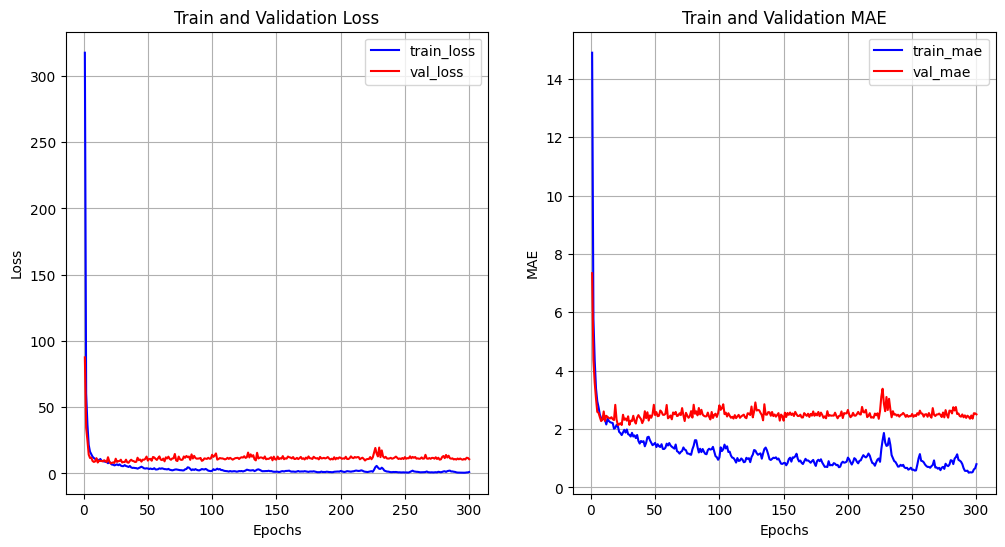

In [23]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
mae = history_dict['mae']
val_mae = history_dict['val_mae']

epochs = range(1, len(loss)+1)
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title("Train and Validation Loss")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()



ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, mae, color='blue', label='train_mae')
ax2.plot(epochs, val_mae, color='red', label='val_mae')
ax2.set_title("Train and Validation MAE")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.grid()
ax2.legend()

plt.show()

<br>

### K-Fold 교차 검증

- **데이터셋의 크기가 매우 작은 경우, [훈련, 검증, 테스트] 데이터로 나누게 되면 과소적합이 일어날 확률이 높음**

- 이를 해결하기 위해 K-Fold 교차 검증 실행
  <br>

  <img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="600">

  <sub>출처: https://scikit-learn.org/stable/modules/cross_validation.html</sub>

<br>

#### `sklearn.model_selection.KFold(n_splits, random_state)`

<br>


### 모델 재구성

In [25]:
tf.random.set_seed(111)

(x_train_full, y_train_full), (x_test, y_test) = load_data(path='boston_housing.npz', test_split=0.2, seed=113)

In [26]:
mean = np.mean(x_train_full, axis=0)
std = np.std(x_train_full, axis=0)

x_train_preprocessed = (x_train_full - mean) / std
x_test_preprocessed = (x_test - mean) / std

x_train, x_val, y_train, y_val = train_test_split(x_train_preprocessed, y_train_full,
                                                  test_size=0.3, random_state=111)

In [33]:
k = 3
kfold = KFold(n_splits=k)

In [41]:
def build_model():
  input = Input(shape=(13, 1), name='input')
  hidden1 = Dense(100, activation='relu',  name='dense1')(input)
  hidden2 = Dense(64, activation='relu', name='dense2')(hidden1)
  hidden3 = Dense(32, activation='relu', name='dense3')(hidden2)
  output = Dense(1, name='output')(hidden3)

  model = Model(inputs=[input], outputs=output)
  
  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae'])
  
  return model

In [44]:
mae_list = []

for train_idx, val_idx in kfold.split(x_train):
  x_train_fold, x_val_fold = x_train[train_idx], x_train[val_idx]
  y_train_fold, y_val_fold = y_train_full[train_idx], y_train_full[val_idx]

  model = build_model()

  model.fit(x_train_fold, y_train_fold, epochs=300,
            validation_data=(x_val_fold, y_val_fold), verbose=False)
  
  _, test_mae = model.evaluate(x_test, y_test)
  mae_list.append(test_mae)

4/4 [==============================] - 0s 4ms/step - loss: 19074.8379 - mae: 59.7318


In [45]:
print(mae_list)

[86.31818389892578, 76.69674682617188, 59.73184585571289]


In [46]:
print(np.mean(mae_list))

74.24892552693684
